## Tutorial for Differential Privacy

In this tutorial, we will apply the differentially private stochastic gradient descent algorithm for data-driven optimization. 
    
As we have seen in the lecture, independent noise is added in iterations to achieve $(\epsilon, \delta)$-DP after $T$ iterations.
    
   

In [2]:
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt

## Logistic regression model

Our running example will be the logistic regression model, where the data is in the form 

$$
x= (z, y),
$$ 
where 
- $z \in \mathbb{R}^{d}$ is the feature vector
- $y \in \{0, 1\}$: binary response.


The probability of observing a label ``1'' given the feature vector $z$ and regression parameter $\theta \in \mathbb{R}^{d}$ is
$$
p(y | z, \theta) = \frac{e^{y z \theta}}{1 + e^{z \theta}}, 
$$


Below, we generate a training and a test set, of sizes $n_{\text{train}}$ and $n_{\text{test}}$, from a logistic regression model whose $d \times 1$ true parameter vector is randomly generated.

In [3]:
# Generate the test and the train data
n_train = 10000
n_test = 10000
n = n_train + n_test

d = 20 # dimension
B1 = 2*(d) # L1 sensitivity
B2 = 2*np.sqrt(d) # L2 sensitivity

theta_true = np.random.normal(size = d)

# Generate data
Z = np.concatenate((np.ones((n, 1)), np.random.uniform(size = (n, d-1))-0.5), axis = 1)
Ztheta = np.matmul(Z, theta_true)
p_true = np.exp(Ztheta)/(1 + np.exp(Ztheta))
y = np.random.uniform(size = n) < p_true

# Split to test-train
Z_train = Z[:n_train]
y_train = y[:n_train]

Z_test = Z[n_train:]
y_test = y[n_train:]

### Calculating the Gradient:

Let
$$
f(\theta; x) = -\ln p(y | z, \theta) = -\ln e^{ y z \theta}  + \ln (1 + e^{z \theta})
$$

Estimate $\theta$ by minimizing
$$
F(\theta; x_{1:n}) := \frac{1}{n} \sum_{i  = 1}^{n} f(\theta; x_{i}) + \lambda \| \theta \|^{2}
$$


It can be shown that
$$
\nabla f(\theta; x) = - \nabla \ln p(y | z, \theta) = -\frac{z y}{1 + e^{\theta z}} + z \frac{e^{\theta z}}{1 + e^{\theta z}}
$$

The following functions calculate this gradient. The first function takes a single pair of $(z, y)$ and calculates the gradient at the given $\theta$. The second function is a vectorized version of the first one, and it is much faster!

In [7]:
def logistic_regression_grad(z, y, theta):
    return -(z*y - z*np.exp(np.dot(theta,z))/(1 + np.exp(np.dot(theta,z))))

def logistic_regression_grad_vec(Z, y, theta):
    denom = (1 + np.exp(np.dot(Z, theta)))
    temp = (np.exp(np.dot(Z, theta))/denom)
    return -(Z*y[:, None] - Z*temp[:,None])

### The main function: DP-SGD

One iteration of the algorithm looks like
    
$$
\theta_{t+1} = \theta_{t} - \eta \left( \frac{1}{m_{t}}  \sum_{i \in U_{t}} \nabla f_{i}(\theta_{t}; x_{i}) + v_{t} \right)
$$

The distribution of the DP noise $v_{t}$ depends on
- DP parameters: $\epsilon, \delta$.
- Sensitivity of $\nabla f_{i}(\theta_{t}; \cdot)$
- $m_{t}$ (privacy amplification by subsampling)
- $T$ (composition property)



In [5]:
def DP_SGD(Z, y, lamda, eta, eps_DP, delta_DP, T, B1, B2, gamma):
    
    # Z, y are the dataset
    # lamda is the regularization parameter
    # eta is the step size
    # eps_DP, delta_DP: DP parameters
    # T: num of iterations
    # B1, B2: L1- and L2- sensitivities of the gradient
    # gamma: subsampling rate for SGD (in [0, 1]); the batch size is data size*gamma (closest integer)
    
    # Get the length of the data
    [n, d] = Z.shape
    
    # check delta first. If delta > 0 and no subsampling, we will use the Gaussian mechanism,
    # if delta = 0, we use Laplace mechanism
    if delta_DP == 0:        
        # We use Laplace noise 
        DP_noise_dist = "Laplace"
        
        # calculate the subsample size
        m = int(n*gamma)
        
        # calculate the parameter of the Laplace noise
        sigma_DP = B1/(m * np.log(1 + np.exp(eps_DP/T - 1)*n/m))
        
    else: #(epsilon, delta)-DP with no subsampling
        # We use Gaussian noise 
        DP_noise_dist = "Gauss"
        gamma == 1
        rho_zCDP = np.sqrt(np.log(1/delta_DP) + eps_DP) - np.sqrt(np.log(1/delta_DP))
        sigma_DP = np.sqrt(T*(B2**2)/((n**2)*(rho_zCDP**2)))
        
    
    # DP SGD Iterations
    theta = np.zeros(d)

    Thetas = np.zeros((T, d))

    for t in range(T):
        # subsample (if needed)
        if gamma < 1:
            U = np.random.choice(n, m)
        else:
            U = np.arange(0, n)

        # Calculate the stochastic gradient (over the subset)
        # avg_grad = np.mean([logistic_regression_grad(Z[i], y[i], theta) for i in U], axis = 0)
        avg_grad = np.mean(logistic_regression_grad_vec(Z[U], y[U], theta), axis = 0)

        # generate the DP noise
        if DP_noise_dist == "Laplace":
            v = np.random.laplace(scale = sigma_DP, size = d)
        elif DP_noise_dist == "Gauss":
            v = np.random.normal(scale = sigma_DP,size = d)

        # Make the update
        theta = theta - eta*(avg_grad + lamda*theta + v)

        Thetas[t] = theta

    return Thetas

## Experiments 
Let us do some experiments with several scenarios. 

In [6]:
# Scenarios [eps_DP, delta_DP, gamma, T, lamda, eta]
Scenarios = [[np.inf, 0, 1, 1000, 0.001, 1], # Scenario 0: non-private
                 [1, 0, 1, 1000, 0.001, 1],# Scenario 1a: (eps, 0)-DP (pure DP) without subs
                 [1, 0, 0.1, 1000, 0.001, 1],# Scenario 1b: (eps, 0)-DP (pure DP) with subs
                 [1, 1/n_train, 1, 1000, 0.001, 1], # Scenario 2a: (eps, delta)-DP without subs
                 [0.5, 1/n_train, 1, 1000, 0.001, 1], # Scenario 2b: (eps, delta)-DP wo subs, more private
                 [0.1, 1/n_train, 1, 1000, 0.001, 1], # Scenario 2c: (eps, delta)-DP wo subs, even more private
                 [1, 1/n_train, 1, 10000, 0.001, 1], # Scenario 2d: (eps, delta)-DP wo subs, even more private, more iterations
                 ]

LC = len(Scenarios)

Thetas = [None] * LC
test_accuracy = np.zeros(LC)
SE = [None] * LC

for i in range(LC):
    print("Experiment", i, "is running...")
    [eps_DP, delta_DP, gamma, T, lamda, eta] = Scenarios[i]
    thetas = DP_SGD(Z_train, y_train, lamda, eta, eps_DP, delta_DP, T, B1, B2, gamma)
    
    # training error vs time
    Est_error = thetas-theta_true
    SE[i] = [np.linalg.norm(Est_error[t, :])**2 for t in range(T)]
    
    # prediction error for the outcomes 
    y_pred = np.matmul(Z_test, thetas[-1]) > 0
    
    test_accuracy[i] = sum(y_pred == y_test)/n_test
    Thetas[i] = thetas
    print("Test accuracy for Scenario", i, "with eps =", eps_DP, "delta =", delta_DP, "gamma=", gamma, "T=", T, "is", test_accuracy[i])
    
print("Experiments are completed")

Experiment 0 is running...
Test accuracy for Scenario 0 with eps = inf delta = 0 gamma= 1 T= 1000 is 0.7446
Experiment 1 is running...
Test accuracy for Scenario 1 with eps = 1 delta = 0 gamma= 1 T= 1000 is 0.7435
Experiment 2 is running...
Test accuracy for Scenario 2 with eps = 1 delta = 0 gamma= 0.1 T= 1000 is 0.7427
Experiment 3 is running...
Test accuracy for Scenario 3 with eps = 1 delta = 0.0001 gamma= 1 T= 1000 is 0.6863
Experiment 4 is running...
Test accuracy for Scenario 4 with eps = 0.5 delta = 0.0001 gamma= 1 T= 1000 is 0.6463
Experiment 5 is running...
Test accuracy for Scenario 5 with eps = 0.1 delta = 0.0001 gamma= 1 T= 1000 is 0.5413
Experiment 6 is running...
Test accuracy for Scenario 6 with eps = 1 delta = 0.0001 gamma= 1 T= 10000 is 0.6367
Experiments are completed


The testing accuracies and running times may already give you some ideas. Here are some observations.

- The best algorithm is the non-private one, which corresponds to $\epsilon = \infty$. 
- Subsampling boosted the algorithm in terms of speed, and there was not much difference with the no-subsamplnig case. 
        -- This is because, while subsampling possibly degrades the performance, it amplifies the privacy so requires less noise, which in turn compensates for the inaccuracy caused by subsampling.
- Most expectedly, as epsilon gets smaller, we have worse performance.
- Note what happens when we increase $T$. In general, after some value of $T$, the algorithm should degenerate because, due to the composition property, more iterations means more DP noise.  


#### Caution:
While interpreting these results, consider the randomness. We run each scenario only once. If we wanted to seriously compare between the scenarios, the randomness should be dealt by having multiple Monte Carlo runs for each scenario and look at the 'average' performance.


   ### Now let us see the training performances, where the abovementioned effects are much more visible.

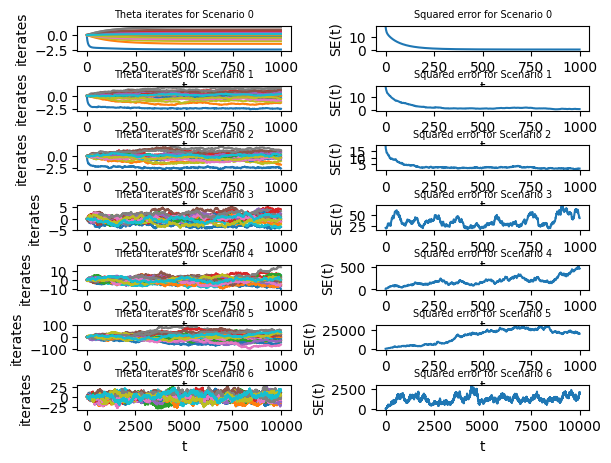

In [6]:
fig, ax = plt.subplots(LC, 2)
for i in range(LC):
    
             
    ax[i, 0].plot(Thetas[i])
    ax[i, 0].set_ylabel('iterates')
    ax[i, 0].set_title('Theta iterates for Scenario %d' % (i),  fontsize=7)
    ax[i, 0].set_xlabel('t')
    
    ax[i, 1].plot(SE[i])
    ax[i, 1].set_ylabel('SE(t)')
    ax[i, 1].set_xlabel('t')
    ax[i, 1].set_title('Squared error for Scenario %d' % (i), fontsize=7)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=1.4)
plt.show()

Try this code with other configurations that you want to explore! For example, try and see what happens when you change 
- n, data size
- d, dimension
- subsampling rate
- etc.

Before whatever you try, try to make a guess on what kind of behaviour you will see. Then, check your guess against the numerical results.

However, recall, again, that

- the code as it is does not support the choice of $\delta > 0$ WITH $\gamma < 1$. However, the details of how to design an $\epsilon, \delta$-DP for that case is given in the lecture slides under the title "Scenario 3".
- consider the randomness in the results due to performing a single Monte Carlo run for each scenario.

If you see any typos, you have any questions, you want to further discuss, etc, please contact me at
sinanyildirim@sabanciuniv.edu 